In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree
import statsmodels.formula.api as smf
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import contextily as ctx
from shapely.geometry import box, LineString, MultiLineString, Point



# 1. Importing the data

In [93]:
zcta_path = Path.cwd().parent / 'data' / 'raw' / 'zcta5_data' / 'zcta5.shp'
zcta = gpd.read_file(zcta_path)
zcta = zcta.to_crs("EPSG:4326")
zcta = gpd.GeoDataFrame(zcta, geometry=zcta["geometry"], crs="EPSG:4326")
zcta.columns = zcta.columns.str.lower()

# importing the data for the first batch of datacenters for which the conversion address -> coordinates worked
datacenters_path = Path.cwd().parent / 'data' / 'processed' / 'successful1.csv'
datacenters = pd.read_csv(datacenters_path)
datacenters.drop('Unnamed: 0', inplace=True, axis=1)

# Convert datacenters to GeoDataFrame
gdf_datacenters = gpd.GeoDataFrame(
    datacenters, 
    geometry=gpd.points_from_xy(datacenters["longitude"], datacenters["latitude"]),
    crs="EPSG:4326"
)
gdf_datacenters.rename({'ZCTA5': 'zcta5'}, axis=1, inplace=True)


# importing the cell tower data
towers_path = Path.cwd().parent / 'data' / 'processed' / 'cell_towers_processed.csv'
towers = pd.read_csv(towers_path)
towers.drop('Unnamed: 0', inplace=True, axis=1)

# Convert cell towers to GeoDataFrame
gdf_towers = gpd.GeoDataFrame(
    towers, 
    geometry=gpd.points_from_xy(towers["lon"], towers["lat"]),
    crs="EPSG:4326"
)
gdf_towers.rename({'ZCTA5': 'zcta5'}, axis=1, inplace=True)

pop_path = Path.cwd().parent / 'data' / 'raw' / 'Population-Density-Final.xlsx'
pop = pd.read_excel(pop_path, sheet_name='DATA')
pop.rename({'Zip': 'zcta5'}, axis=1, inplace=True)
pop["zcta5"] = pop["zcta5"].astype(str)


energy_path = Path.cwd().parent / 'data' / 'raw' / 'transmission_line_data' / 'Electric_Power_Transmission_Lines_B.shp'
energy =  gpd.read_file(energy_path)
energy.rename({'ZCTA5': 'zcta5'}, axis=1, inplace=True)

In [87]:
# Select the columns needed for the regression and drop rows with missing values
df_reg = datacenters[['MW_total_power', 'provider', 'sqft_total_space', 'state']].dropna()

# Function to remove outliers based on the IQR method
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 4 * IQR
    upper_bound = Q3 + 4 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Remove outliers from MW_total_power and sqft_total_space
df_reg = remove_outliers_iqr(df_reg, 'MW_total_power')
df_reg = remove_outliers_iqr(df_reg, 'sqft_total_space')

# Run the regression: MW_total_power is predicted by provider, sqft_total_space, and state.
# The categorical variables 'provider' and 'state' are automatically dummy-coded by statsmodels.
model = smf.ols(formula='MW_total_power ~ provider + sqft_total_space + state', data=df_reg).fit()

# Print the summary of the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         MW_total_power   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     4.064
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           5.85e-33
Time:                        16:17:36   Log-Likelihood:                -2497.0
No. Observations:                 636   AIC:                             5332.
Df Residuals:                     467   BIC:                             6085.
Df Model:                         168                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [4]:
datacenters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       1605 non-null   object 
 1   name                      1605 non-null   object 
 2   address                   1605 non-null   object 
 3   provider                  1605 non-null   object 
 4   MW_total_power            748 non-null    float64
 5   miles_to_nearest_airport  1585 non-null   float64
 6   sqft_colocation_space     767 non-null    float64
 7   sqft_total_space          1030 non-null   float64
 8   number                    1529 non-null   float64
 9   street                    1605 non-null   object 
 10  municipality              1602 non-null   object 
 11  state                     1549 non-null   object 
 12  latitude                  1605 non-null   float64
 13  longitude                 1605 non-null   float64
dtypes: float

In [5]:
towers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323039 entries, 0 to 323038
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   cell     323039 non-null  int64  
 1   radio    323039 non-null  object 
 2   lon      323039 non-null  float64
 3   lat      323039 non-null  float64
 4   range    323039 non-null  int64  
 5   created  323039 non-null  object 
 6   updated  323039 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 17.3+ MB


In [6]:
hyper = datacenters[
    (datacenters.provider == 'Amazon AWS') | 
    (datacenters.provider == 'Microsoft Azure') |
    (datacenters.provider == 'Google')  
                    ]

In [7]:

# Earth's radius in kilometers
EARTH_RADIUS_KM = 6371.0

# ----------------------------
# Prepare the towers data for spatial queries

# Convert towers' latitudes and longitudes from degrees to radians
towers_rad = np.deg2rad(towers[['lat', 'lon']].values)

# Build a BallTree using the haversine metric.
# (Note: the haversine metric in BallTree returns distances in radians.)
tower_tree = BallTree(towers_rad, metric='haversine')

# ----------------------------
# Prepare the datacenters coordinates

# Convert datacenters' latitudes and longitudes from degrees to radians
datacenters_rad = np.deg2rad(datacenters[['latitude', 'longitude']].values)

# Define the search radius: 10 km, converted to radians.
# (distance_in_radians = distance_in_km / Earth_radius_in_km)
search_radius = 10.0 / EARTH_RADIUS_KM

# ----------------------------
# Query the BallTree for each datacenter:
# For each datacenter coordinate, query for towers within the search radius.
indices_within_radius = tower_tree.query_radius(datacenters_rad, r=search_radius)

# Compute the count for each datacenter
datacenters['towers_count_10km'] = [len(indices) for indices in indices_within_radius]


In [8]:

def plot_us_map(df_datacenters, towers, path):
    # Load US states shapefile
    world = gpd.read_file(path)
    
    # Filter using the correct country code column
    usa = world[world.adm0_a3 == 'USA']  # Key fix here :cite[2]:cite[10]

    # Create plot
    fig, ax = plt.subplots(figsize=(20, 12))
    
    # Plot US boundaries
    usa.boundary.plot(ax=ax, linewidth=0.8, color='black')
    
    # Plot datacenters (red points)
    ax.scatter(df_datacenters['longitude'], 
               df_datacenters['latitude'], 
               c='red', s=40, alpha=0.7, 
               label='Data Centers (1,605)',
               edgecolor='darkred')
    
    # # Plot towers (blue points)
    # ax.scatter(towers['lon'], 
    #            towers['lat'], 
    #            c='blue', s=5, alpha=0.1, 
    #            label='Cell Towers (323k)',
    #            edgecolor='none')
    
    # Set continental US limits
    ax.set_xlim(-130, -65)
    ax.set_ylim(24, 50)
    
    plt.title('US Data Centers and Cell Towers Distribution')
    plt.legend()
    plt.show()

In [9]:
shapefile_path = Path.cwd().parent / 'data' / 'raw' / '110m_cultural' / 'ne_110m_admin_1_states_provinces_lakes.shp'

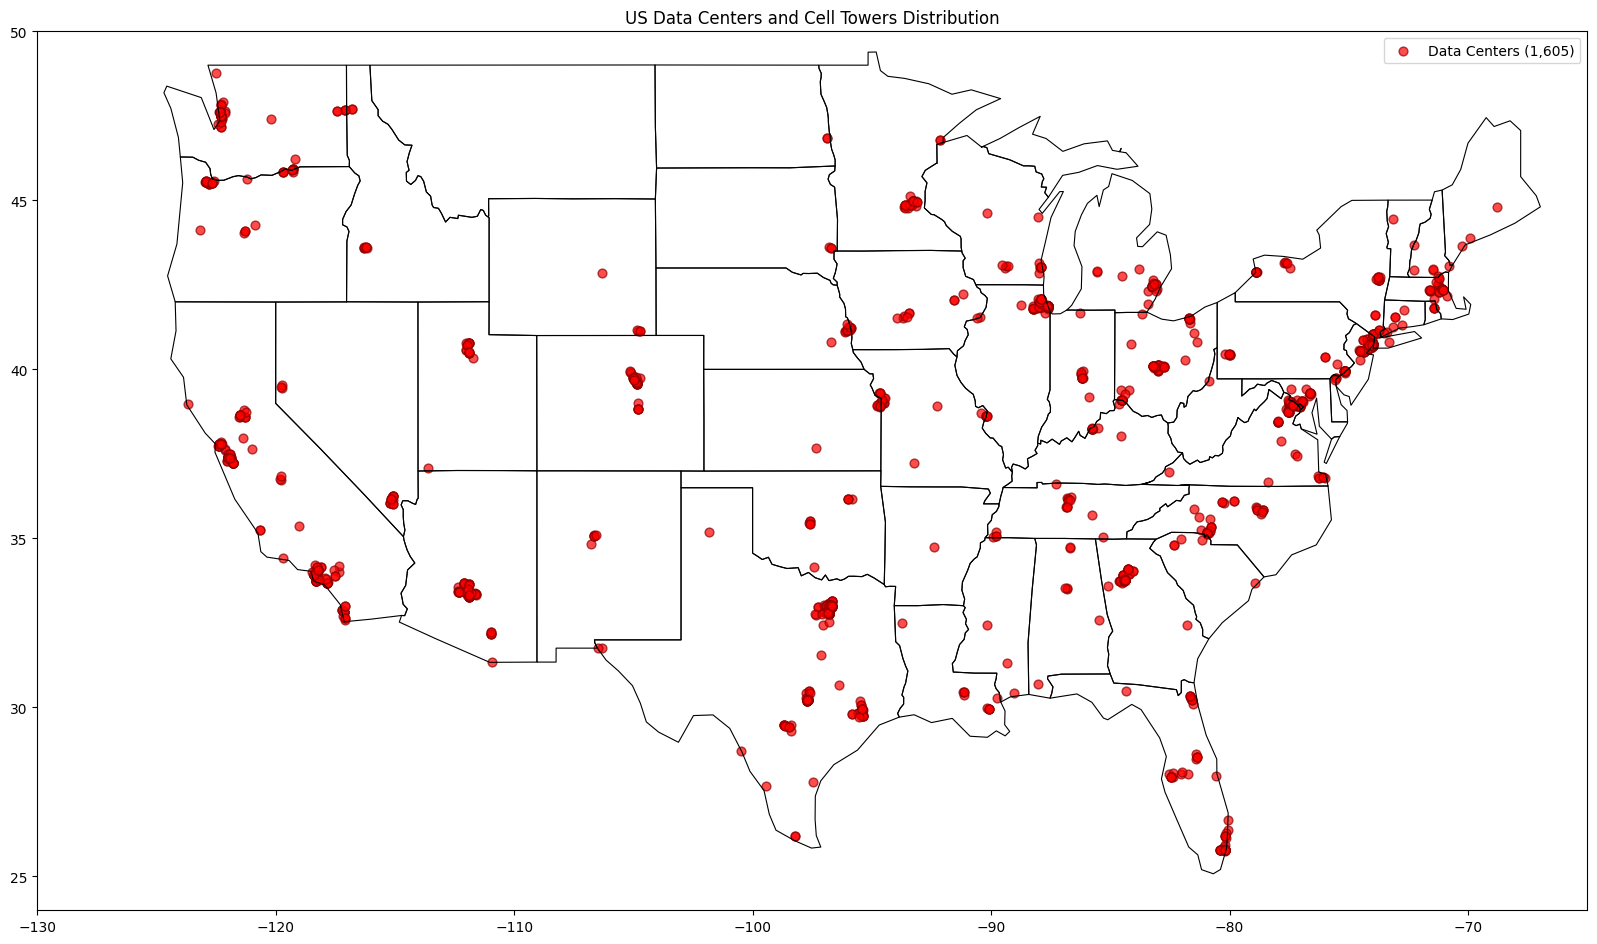

In [10]:
# Usage example:
plot_us_map(datacenters, towers, shapefile_path)

In [11]:
hyper.provider.value_counts()

provider
Amazon AWS         57
Google             10
Microsoft Azure     6
Name: count, dtype: int64

In [12]:
# ✅ Define the voltage classification function
def classify_voltage(voltage):
    if voltage < 1:
        return "Low Voltage (<1kV)"
    elif 1 <= voltage < 69:
        return "Medium Voltage (1-69kV)"
    elif 69 <= voltage < 230:
        return "High Voltage (69-230kV)"
    elif 230 <= voltage < 765:
        return "Extra-High Voltage (230-765kV)"
    else:
        return "Ultra-High Voltage (>765kV)"

# ✅ Apply classification
energy["Voltage_Class"] = energy["VOLTAGE"].apply(classify_voltage)

In [ ]:
towers_5g

In [51]:
energy_dallas = energy[energy.geometry.intersects(dallas_geom)].copy()
gdf_datacenters_dallas = gdf_datacenters[gdf_datacenters.geometry.intersects(dallas_geom)].copy()
gdf_towers_dallas = gdf_towers[gdf_towers.geometry.intersects(dallas_geom)].copy()
towers_5g_dallas = gdf_towers[towers_5g.geometry.intersects(dallas_geom)].copy()


/Users/leonardogomes/myproject/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

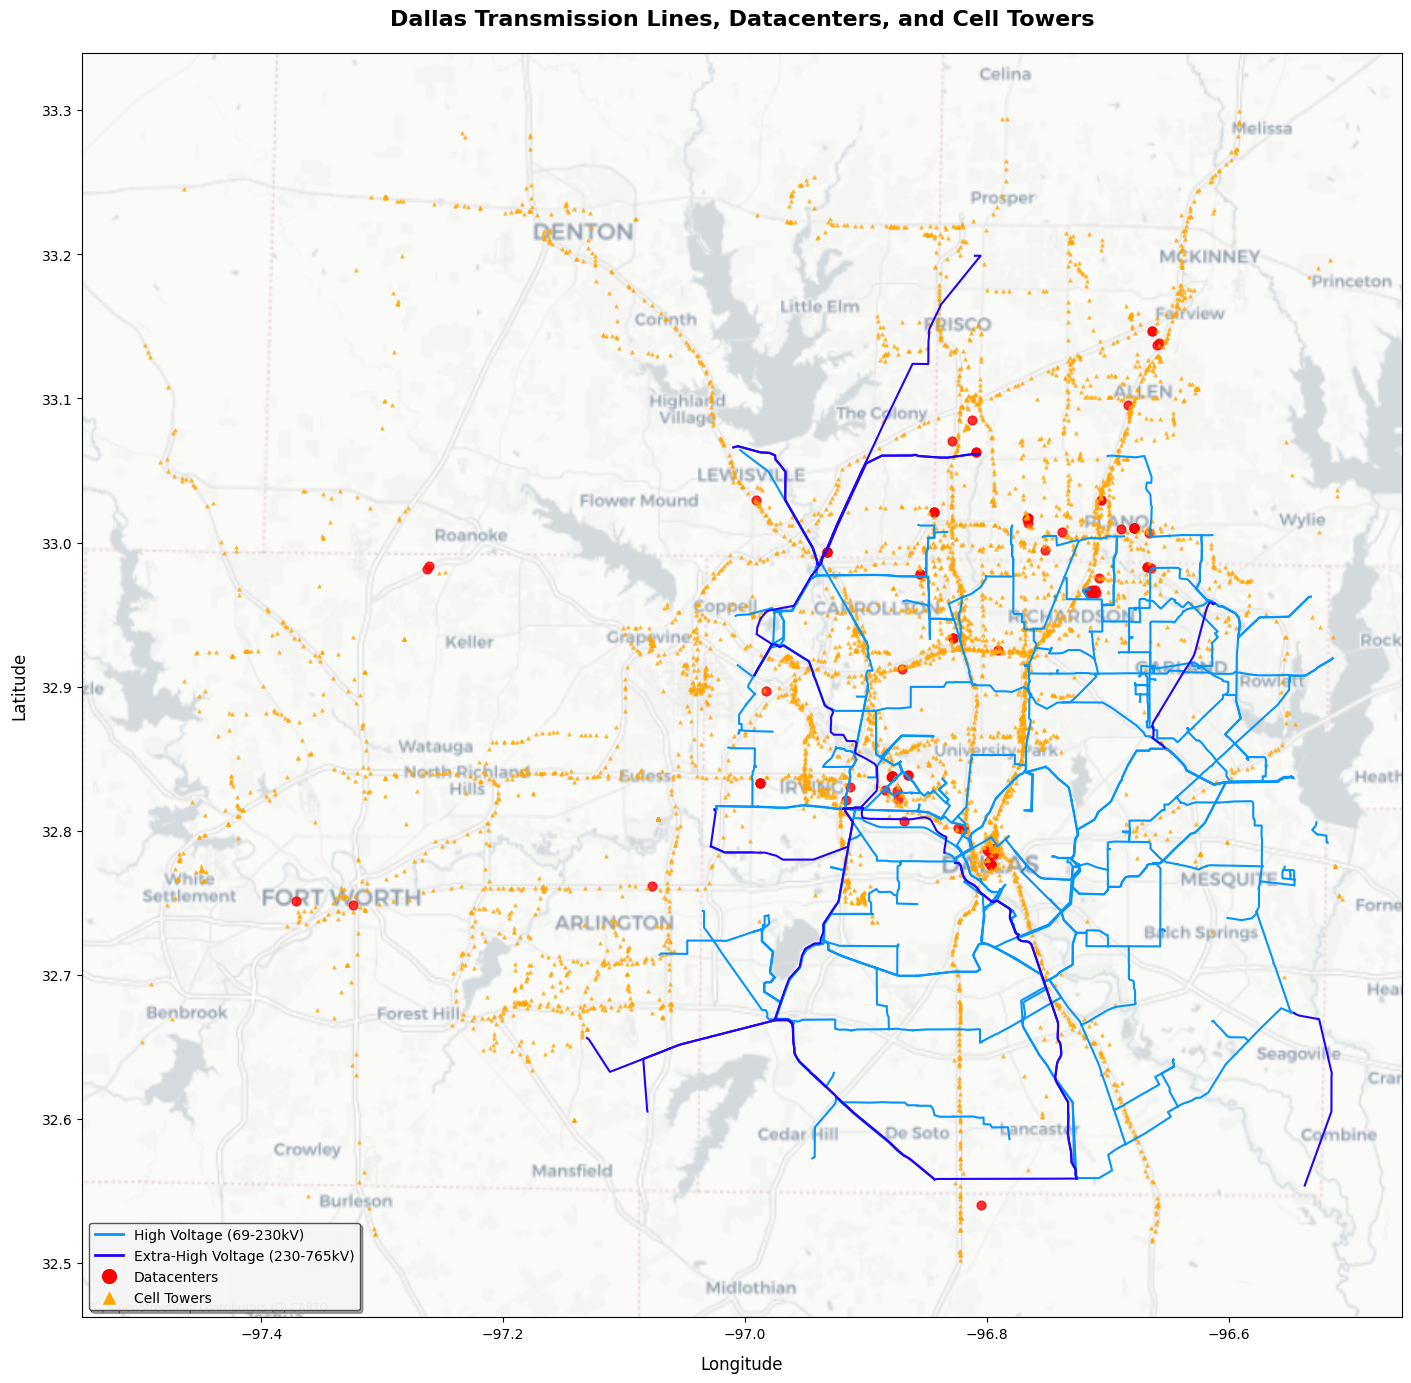

In [204]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import contextily as ctx
from shapely.geometry import LineString, MultiLineString

# ✅ Define Dallas bounding box (approximate lat/lon range)
dallas_bbox = {
    "minx": -97.5, "maxx": -96.5,
    "miny": 32.5, "maxy": 33.3
}

# ✅ Filter transmission lines within Dallas
energy_dallas_filtered = energy_dallas[
    (energy_dallas.geometry.bounds.minx >= dallas_bbox["minx"]) & 
    (energy_dallas.geometry.bounds.maxx <= dallas_bbox["maxx"]) & 
    (energy_dallas.geometry.bounds.miny >= dallas_bbox["miny"]) & 
    (energy_dallas.geometry.bounds.maxy <= dallas_bbox["maxy"])
]

# ✅ Filter only High Voltage and Extra-High Voltage lines
energy_dallas_filtered = energy_dallas_filtered[
    energy_dallas_filtered["Voltage_Class"].isin(["High Voltage (69-230kV)", "Extra-High Voltage (230-765kV)"])
]

# ✅ Filter datacenters within Dallas
gdf_datacenters_dallas = gdf_datacenters[
    (gdf_datacenters.geometry.x >= dallas_bbox["minx"]) & 
    (gdf_datacenters.geometry.x <= dallas_bbox["maxx"]) & 
    (gdf_datacenters.geometry.y >= dallas_bbox["miny"]) & 
    (gdf_datacenters.geometry.y <= dallas_bbox["maxy"])
]

# ✅ Filter cell towers within Dallas
gdf_towers_dallas = gdf_towers[
    (gdf_towers.geometry.x >= dallas_bbox["minx"]) & 
    (gdf_towers.geometry.x <= dallas_bbox["maxx"]) & 
    (gdf_towers.geometry.y >= dallas_bbox["miny"]) & 
    (gdf_towers.geometry.y <= dallas_bbox["maxy"])
]

# ✅ Define voltage classification colors (Only High & Extra-High)
voltage_colors = {
    "High Voltage (69-230kV)": "#0394fc",
    "Extra-High Voltage (230-765kV)": "#2003fc",
}

# ✅ Plot Everything Together
fig, ax = plt.subplots(figsize=(14, 14), constrained_layout=True)

# ✅ Plot Transmission Lines (Only High & Extra-High Voltage)
for category, color in voltage_colors.items():
    subset = energy_dallas_filtered[energy_dallas_filtered["Voltage_Class"] == category]
    for line in subset.geometry:
        if isinstance(line, LineString):
            x, y = line.xy
            ax.plot(x, y, color=color, linewidth=1.5, label=category)
        elif isinstance(line, MultiLineString):
            for segment in line.geoms:
                x, y = segment.xy
                ax.plot(x, y, color=color, linewidth=1.5, label=category)

# ✅ Plot Datacenters (Red Circles)
gdf_datacenters_dallas.plot(ax=ax, color="red", markersize=40, label="Datacenters", alpha=0.8)

# ✅ Plot Cell Towers (Orange Triangles)
gdf_towers_dallas.plot(ax=ax, color="orange", markersize=5, marker="^", label="Cell Towers", alpha=0.6)

# ✅ Add a basemap
ctx.add_basemap(ax, crs=gdf_datacenters_dallas.crs, source=ctx.providers.CartoDB.Positron)

# ✅ Formatting
ax.set_title("Dallas Transmission Lines, Datacenters, and Cell Towers", fontsize=16, pad=20, weight="bold")
ax.set_xlabel("Longitude", fontsize=12, labelpad=10)
ax.set_ylabel("Latitude", fontsize=12, labelpad=10)

# ✅ Create a Custom Legend with Correct Icons
legend_elements = [
    # Transmission Lines (lines in legend)
    mlines.Line2D([], [], color="#0394fc", linewidth=2, label="High Voltage (69-230kV)"),
    mlines.Line2D([], [], color="#2003fc", linewidth=2, label="Extra-High Voltage (230-765kV)"),
    
    # Datacenters (circle markers with white edge)
    mlines.Line2D([], [], 
                 marker='o', 
                 color='red',            # Inner color
                 markeredgecolor='white', # Edge color
                 markersize=12,          # Size relative to legend
                 linestyle='None',
                 label="Datacenters"),
    
    # Cell Towers (triangle markers with white edge)
    mlines.Line2D([], [], 
                 marker='^', 
                 color='orange',         # Inner color
                 markeredgecolor='white', # Edge color
                 markersize=12,          # Size relative to legend
                 linestyle='None',
                 label="Cell Towers")
]

# ✅ Add legend with proper styling
ax.legend(handles=legend_elements, 
          loc="lower left", 
          fontsize=10, 
          title_fontsize=12,
          frameon=True, 
          shadow=True, 
          facecolor='white',
          edgecolor='#404040',
          framealpha=0.9)

# ✅ Show the map
plt.show()

In [55]:
# Count datacenters per ZIP code
datacenter_counts = gdf_datacenters.groupby("zcta5").size().reset_index(name="datacenter_count")

# Count cell towers per ZIP code
tower_counts = gdf_towers.groupby("zcta5").size().reset_index(name="tower_count")

In [90]:
# Ensure transmission lines are in the correct CRS
if energy.crs != "EPSG:4326":
    energy = energy.to_crs("EPSG:4326")

# Perform spatial join: Assign ZIP codes to transmission lines
energy_zip = gpd.sjoin(energy, zcta, predicate="intersects")

# Compute total transmission line length per ZIP
energy_zip["line_length_km"] = energy_zip.geometry.length / 1000  # Convert meters to km
line_density = energy_zip.groupby("zcta5")["line_length_km"].sum().reset_index()


/var/folders/wy/sh80l6n90g521zb1r40wbjs00000gn/T/ipykernel_49149/2247480915.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  energy_zip["line_length_km"] = energy_zip.geometry.length / 1000  # Convert meters to km


In [229]:
# Merge population density with infrastructure data
merged_df = pop.merge(datacenter_counts, on="zcta5", how="left")
merged_df = merged_df.merge(tower_counts, on="zcta5", how="left")
merged_df = merged_df.merge(line_density, on="zcta5", how="left")

# Fill NaN values (since some ZIPs may have no datacenters or towers)
merged_df.fillna(0, inplace=True)


In [230]:
# ✅ Ensure the CRS is in a projected coordinate system for accurate area calculation
if zcta.crs != "EPSG:3857":  
    zcta = zcta.to_crs("EPSG:3857")  # Convert to a metric-based CRS (meters)

# ✅ Compute area in square kilometers
zcta["area_km2"] = zcta.geometry.area / 1e6  # Convert from square meters to square kilometers

# ✅ Keep only necessary columns
zcta_area = zcta[["zcta5", "area_km2"]]

# ✅ Merge the area data with the existing dataset
merged_df = merged_df.merge(zcta_area, left_on="zcta5", right_on="zcta5", how="left")

In [231]:
# ✅ Compute density of cell towers
merged_df["tower_density_km2"] = merged_df["tower_count"] / merged_df["area_km2"]


In [232]:
# ✅ Convert to a binary target variable
merged_df["datacenter_built"] = (merged_df["datacenter_count"] > 0).astype(int)

# ✅ Drop the original `datacenter_count` column
merged_df.drop(columns=["datacenter_count"], inplace=True)


In [233]:
merged_df.drop(columns=["City", "St", "CitySt", "County", "Country", "Coordinates"], inplace=True)

In [234]:
merged_df

,zcta5,population,density,State,lat,long,tower_count,line_length_km,area_km2,tower_density_km2,datacenter_built
0,92337,38868,1049.1,CA,34.0498,-117.4706,11.0,0.002710,51.817713,0.212283,0
1,92338,0,0.0,CA,34.7211,-116.1600,12.0,0.008693,360.465786,0.033290,0
2,92339,1185,32.3,CA,34.0937,-116.9362,0.0,0.000080,298.810557,0.000000,0
3,92340,1185,32.3,CA,34.4264,-117.3009,0.0,0.000000,NaN,NaN,0
4,92341,203,22.4,CA,34.2348,-117.0660,0.0,0.000000,38.056430,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
40954,82442,710,0.4,WY,43.9978,-107.4153,0.0,0.000344,3072.602096,0.000000,0
40955,82701,5486,1.1,WY,43.8511,-104.2262,1.0,0.007618,8925.532364,0.000112,0
40956,82715,0,0.0,WY,44.0775,-104.1383,0.0,0.000000,NaN,NaN,0
40957,82723,246,1.1,WY,43.9990,-104.4226,0.0,0.007616,685.437617,0.000000,0


# Machile Learning Modelling

In [235]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [236]:
# ✅ Select features to normalize
cols_to_scale = ["population", "density", "tower_density_km2"]

# ✅ Apply MinMaxScaler
scaler = MinMaxScaler()
merged_df[cols_to_scale] = scaler.fit_transform(merged_df[cols_to_scale])
merged_df.drop('State', axis=1, inplace=True)

In [237]:
merged_df.fillna(0, inplace=True)  # Replace NaNs with 0

In [238]:
# ✅ Define features (X) and target (y)
X = merged_df.drop(columns=["datacenter_built", "zcta5"])  # Exclude target & ZIP code
y = merged_df["datacenter_built"]  # Binary target (1 = datacenter built)

# ✅ Train Logistic Regression Model on Full Dataset
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# ✅ Predict probabilities for all ZIP codes in the dataset
merged_df["predicted_prob"] = model.predict_proba(X)[:, 1]  # Extract probability of "1"


In [239]:
zcta_map = zcta.merge(merged_df, left_on="zcta5", right_on="zcta5", how="left")

In [240]:
# ✅ Define Dallas bounding box (approximate lat/lon range)
dallas_bbox = {
    "minx": -97.5, "maxx": -96.5,
    "miny": 32.5, "maxy": 33.3
}

# ✅ Separate Dallas region (Test Set)
dallas_df = merged_df[
    (merged_df["long"] >= dallas_bbox["minx"]) & (merged_df["long"] <= dallas_bbox["maxx"]) &
    (merged_df["lat"] >= dallas_bbox["miny"]) & (merged_df["lat"] <= dallas_bbox["maxy"])
].copy()

# ✅ Define the Train Set (Everything except Dallas)
train_df = merged_df.drop(dallas_df.index)

# ✅ Define features (X) and target (y) for training
X_train = train_df.drop(columns=["datacenter_built", "zcta5"])
y_train = train_df["datacenter_built"]

# ✅ Train Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [241]:
# ✅ Define features for Dallas Test Set
X_test_dallas = dallas_df.drop(columns=["zcta5", "datacenter_built"])

# ✅ Predict probabilities for Dallas
dallas_df["predicted_prob"] = model.predict_proba(X_test_dallas)[:, 1]

In [242]:
zcta_dallas = zcta.merge(dallas_df, left_on="zcta5", right_on="zcta5", how="inner")

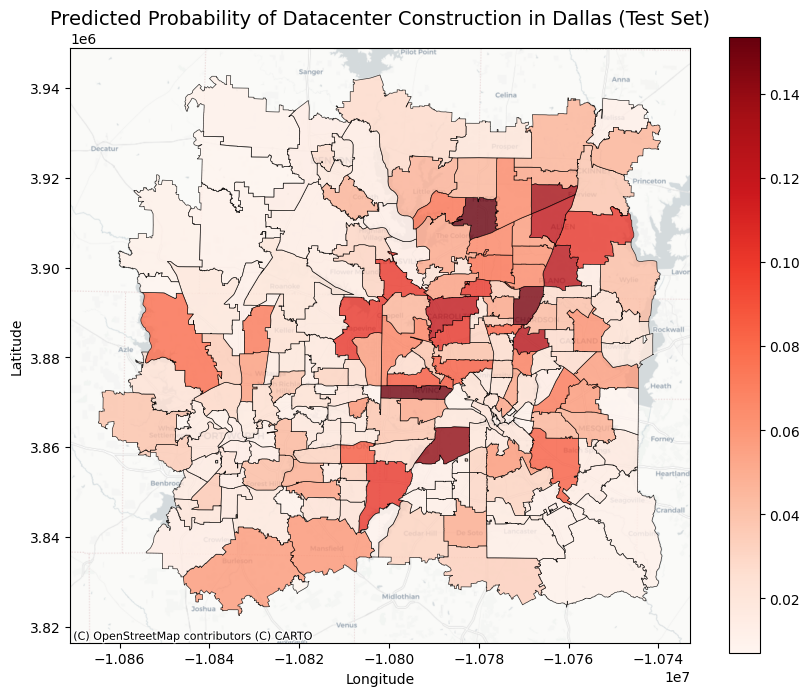

In [244]:
import matplotlib.pyplot as plt
import contextily as ctx

# ✅ Set up the figure
fig, ax = plt.subplots(figsize=(10, 8))

# ✅ Plot Dallas ZIP codes with predicted probabilities
zcta_dallas.plot(column="predicted_prob", cmap="Reds", linewidth=0.5, edgecolor="black",
                 legend=True, alpha=0.8, ax=ax)

# ✅ Add a basemap for geographic context
ctx.add_basemap(ax, crs=zcta_dallas.crs, source=ctx.providers.CartoDB.Positron)

# ✅ Formatting
ax.set_title("Predicted Probability of Datacenter Construction in Dallas (Test Set)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# ✅ Show the map
plt.show()

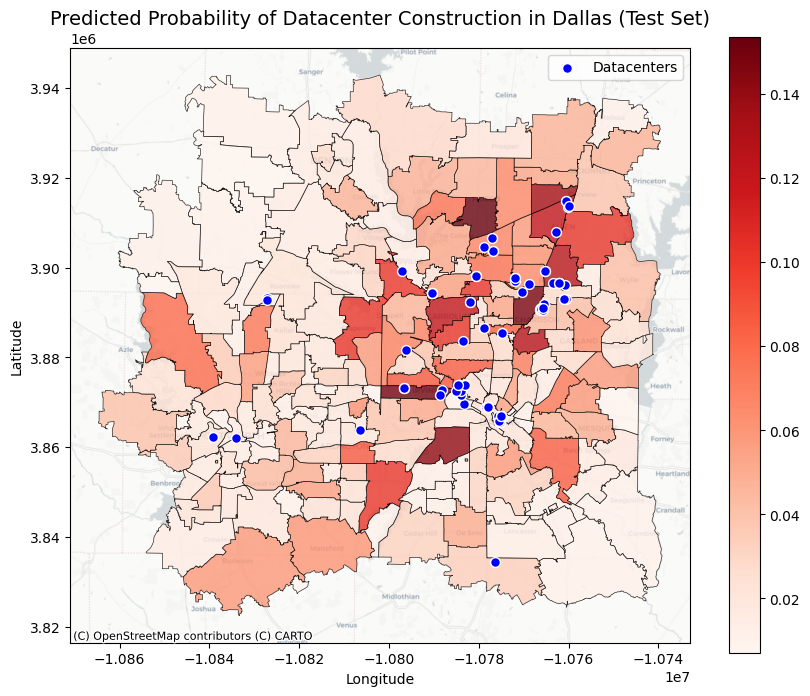

In [252]:
# ✅ Reproject datacenters to match ZCTA CRS if necessary
if gdf_datacenters_dallas.crs != zcta_dallas.crs:
    gdf_datacenters_dallas = gdf_datacenters_dallas.to_crs(zcta_dallas.crs)

# ✅ Set up the figure
fig, ax = plt.subplots(figsize=(10, 8))

# ✅ Plot Dallas ZIP codes with predicted probabilities
zcta_dallas.plot(column="predicted_prob", cmap="Reds", linewidth=0.5, edgecolor="black",
                 legend=True, alpha=0.8, ax=ax)

# ✅ Overlay datacenter locations
gdf_datacenters_dallas.plot(ax=ax, marker="o", color="blue", markersize=50, edgecolor="white", label="Datacenters")

# ✅ Add a basemap for geographic context
ctx.add_basemap(ax, crs=zcta_dallas.crs, source=ctx.providers.CartoDB.Positron)

# ✅ Formatting
ax.set_title("Predicted Probability of Datacenter Construction in Dallas (Test Set)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

# ✅ Show the map
plt.show()
